# Лабораторная работа 5: Деревья решений

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random
from collections import Counter
from ucimlrepo import fetch_ucirepo

# Настройка отображения графиков
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 6)

## 1. Загрузка и предварительная обработка данных

In [91]:
print("1. ПРЕДВАРИТЕЛЬНАЯ ОБРАБОТКА ДАННЫХ")
print("=" * 50)

# Загрузка датасета
mushroom = fetch_ucirepo(id=73)

# Данные
X = mushroom.data.features
y = mushroom.data.targets

# Преобразуем целевую переменную в бинарный формат (0 - edible, 1 - poisonous)
y_binary = (y["poisonous"] == "p").astype(int)

# Обработка пропущенных значений
X = X.fillna("unknown")

print("Информация о датасете:")
print(f"Размерность признаков: {X.shape}")
print(f"Размерность целевой переменной: {y_binary.shape}")
print()

print("Проверка отсутствующих значений:")
print(X.isnull().sum().sum())
print()

print("Первые 5 строк данных:")
print(pd.concat([X.head(), y_binary.head()], axis=1))

1. ПРЕДВАРИТЕЛЬНАЯ ОБРАБОТКА ДАННЫХ
Информация о датасете:
Размерность признаков: (8124, 22)
Размерность целевой переменной: (8124,)

Проверка отсутствующих значений:
0

Первые 5 строк данных:
  cap-shape cap-surface cap-color bruises odor gill-attachment gill-spacing  \
0         x           s         n       t    p               f            c   
1         x           s         y       t    a               f            c   
2         b           s         w       t    l               f            c   
3         x           y         w       t    p               f            c   
4         x           s         g       f    n               f            w   

  gill-size gill-color stalk-shape  ... stalk-color-above-ring  \
0         n          k           e  ...                      w   
1         b          k           e  ...                      w   
2         b          n           e  ...                      w   
3         n          n           e  ...                      w   
4 

## 2. Статистика и визуализация данных

In [92]:
print("2. СТАТИСТИКА И ВИЗУАЛИЗАЦИЯ ДАННЫХ")
print("=" * 50)

# Базовая статистика по целевой переменной
print("Распределение классов:")
class_dist = Counter(y_binary)
for cls, count in class_dist.items():
    percentage = count / len(y_binary) * 100
    label = "poisonous" if cls == 1 else "edible"
    print(f"{label}: {count} примеров ({percentage:.1f}%)")
print()

2. СТАТИСТИКА И ВИЗУАЛИЗАЦИЯ ДАННЫХ
Распределение классов:
poisonous: 3916 примеров (48.2%)
edible: 4208 примеров (51.8%)



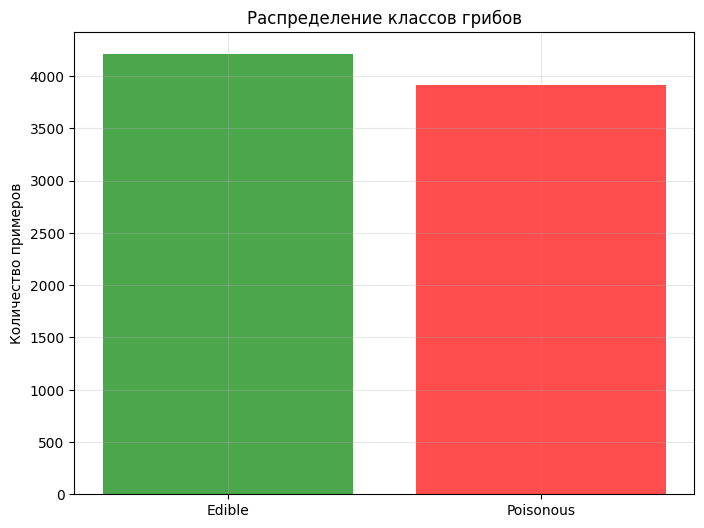

In [93]:
# Визуализация распределения классов
plt.figure(figsize=(8, 6))
plt.bar(["Edible", "Poisonous"], [class_dist[0], class_dist[1]], color=["green", "red"], alpha=0.7)
plt.title("Распределение классов грибов")
plt.ylabel("Количество примеров")
plt.grid(True, alpha=0.3)
plt.show()

## 3. Реализация DecisionTree

In [94]:
print("3. РЕАЛИЗАЦИЯ DecisionTree")
print("=" * 50)


class Node:
    """Узел дерева решений"""

    def __init__(self, feature=None, value=None, results=None, children=None):
        self.feature = feature  # Признак для разделения
        self.value = value  # Значение признака
        self.results = results  # Распределение классов (для листа)
        self.children = children or []  # Дочерние узлы


class DecisionTree:
    """Дерево решений для классификации"""

    def __init__(self, max_depth=10, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None

    def calculate_gini(self, y):
        """Вычисление коэффициента Джини"""
        if len(y) == 0:
            return 0

        class_counts = Counter(y)
        gini = 1.0

        for count in class_counts.values():
            probability = count / len(y)
            gini -= probability**2

        return gini

    def split_data(self, X, y, feature, value):
        """Разделение данных по значению признака"""
        left_X, left_y = [], []
        right_X, right_y = [], []

        for i in range(len(X)):
            if X[i][feature] == value:
                left_X.append(X[i])
                left_y.append(y[i])
            else:
                right_X.append(X[i])
                right_y.append(y[i])

        return left_X, left_y, right_X, right_y

    def find_best_split(self, X, y, features):
        """Поиск лучшего разделения"""
        best_gini = float("inf")
        best_feature = None
        best_value = None
        best_splits = None

        current_gini = self.calculate_gini(y)

        for feature in features:
            # Получаем все уникальные значения признака
            values = set([x[feature] for x in X])

            for value in values:
                left_X, left_y, right_X, right_y = self.split_data(X, y, feature, value)

                if len(left_y) == 0 or len(right_y) == 0:
                    continue

                # Взвешенный коэффициент Джини
                left_weight = len(left_y) / len(y)
                right_weight = len(right_y) / len(y)

                weighted_gini_left = left_weight * self.calculate_gini(left_y)
                weighted_gini_right = right_weight * self.calculate_gini(right_y)
                weighted_gini = weighted_gini_left + weighted_gini_right

                if weighted_gini < best_gini:
                    best_gini = weighted_gini
                    best_feature = feature
                    best_value = value
                    best_splits = (left_X, left_y, right_X, right_y)

        # Если улучшение незначительное, не разделяем
        if best_gini >= current_gini - 0.001:
            return None, None, None

        return best_feature, best_value, best_splits

    def build_tree(self, X, y, features, depth=0):
        """Рекурсивное построение дерева"""

        # Базовые случаи остановки
        if len(y) < self.min_samples_split or depth >= self.max_depth or len(set(y)) == 1:
            return Node(results=Counter(y))

        # Поиск лучшего разделения
        feature, value, splits = self.find_best_split(X, y, features)

        if feature is None:
            return Node(results=Counter(y))

        left_X, left_y, right_X, right_y = splits

        # Рекурсивное построение дочерних узлов
        left_child = self.build_tree(left_X, left_y, features, depth + 1)
        right_child = self.build_tree(right_X, right_y, features, depth + 1)

        return Node(feature=feature, value=value, children=[left_child, right_child])

    def fit(self, X, y):
        """Обучение дерева"""
        # Преобразуем DataFrame в список словарей для удобства
        X_list = X.to_dict("records")
        y_list = y.tolist()

        features = list(X.columns)

        self.root = self.build_tree(X_list, y_list, features)

    def predict_single(self, x):
        """Предсказание для одного примера"""
        node = self.root

        while node.children:
            if x[node.feature] == node.value:
                node = node.children[0]  # Левый ребенок
            else:
                node = node.children[1]  # Правый ребенок

        # Возвращаем наиболее частый класс
        if node.results:
            return max(node.results.items(), key=lambda x: x[1])[0]
        return 0

    def predict(self, X):
        """Предсказание для набора данных"""
        X_list = X.to_dict("records")
        return [self.predict_single(x) for x in X_list]

    def predict_proba_single(self, x):
        """Вероятности классов для одного примера"""
        node = self.root

        while node.children:
            if x[node.feature] == node.value:
                node = node.children[0]
            else:
                node = node.children[1]

        if node.results:
            total = sum(node.results.values())
            proba_1 = node.results.get(1, 0) / total
            return [1 - proba_1, proba_1]
        return [0.5, 0.5]

    def predict_proba(self, X):
        """Вероятности классов для набора данных"""
        X_list = X.to_dict("records")
        probabilities = []

        for x in X_list:
            proba = self.predict_proba_single(x)
            probabilities.append(proba[1])  # Вероятность класса 1

        return probabilities


print("Класс DecisionTree успешно реализован")

3. РЕАЛИЗАЦИЯ DecisionTree
Класс DecisionTree успешно реализован


## 4. Отбор признаков и построение модели

In [95]:
print("4. ОТБОР ПРИЗНАКОВ И ПОСТРОЕНИЕ МОДЕЛИ")
print("=" * 50)

# Устанавливаем seed для воспроизводимости результатов
random.seed(413732)


def select_features(X, method="sqrt"):
    """
    Отбор признаков для дерева решений
    """
    n_features = X.shape[1]

    if method == "sqrt":
        n_selected = int(math.sqrt(n_features))
    else:
        n_selected = n_features

    selected_indices = random.sample(range(n_features), n_selected)
    selected_features = X.columns[selected_indices].tolist()

    return selected_features, selected_indices


def train_test_split(X, y, test_size=0.3, random_state=None):
    """Разделение на обучающую и тестовую выборки"""
    if random_state is not None:
        np.random.seed(random_state)

    n = len(X)
    test_indices = np.random.choice(n, size=int(n * test_size), replace=False)
    train_indices = np.setdiff1d(np.arange(n), test_indices)

    X_train = X.iloc[train_indices]
    X_test = X.iloc[test_indices]
    y_train = y.iloc[train_indices]
    y_test = y.iloc[test_indices]

    return X_train, X_test, y_train, y_test


# Отбор признаков
selected_features, selected_indices = select_features(X)
X_selected = X[selected_features].copy()

print(f"Отобрано {len(selected_features)} признаков из {X.shape[1]}:")
print(selected_features)
print()

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(
    X_selected,
    y_binary,
    test_size=0.3,
    random_state=42,
)

print(f"Обучающая выборка: {len(X_train)} примеров")
print(f"Тестовая выборка: {len(X_test)} примеров")
print()

# Обучение модели
tree = DecisionTree(max_depth=5, min_samples_split=10)
tree.fit(X_train, y_train)

print("Модель дерева решений успешно обучена")

4. ОТБОР ПРИЗНАКОВ И ПОСТРОЕНИЕ МОДЕЛИ
Отобрано 4 признаков из 22:
['gill-size', 'cap-color', 'population', 'bruises']

Обучающая выборка: 5687 примеров
Тестовая выборка: 2437 примеров

Модель дерева решений успешно обучена


## 5. Оценка модели

5. ОЦЕНКА МОДЕЛИ
РЕЗУЛЬТАТЫ ОЦЕНКИ:
------------------------------
Accuracy: 0.9307
Precision: 0.9127
Recall: 0.9475

МАТРИЦА ОШИБОК:
------------------------------
TP: 1119, FP: 107
FN: 62, TN: 1149



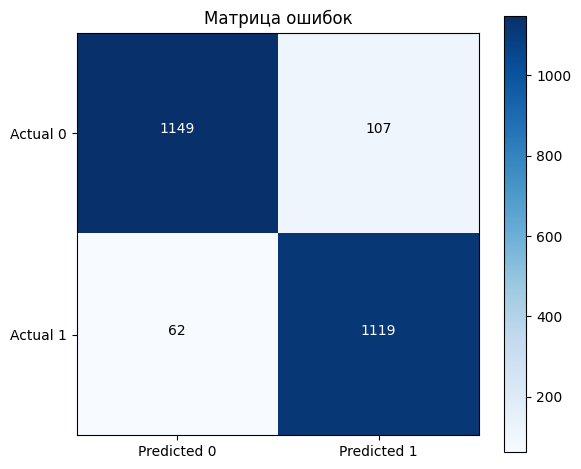

In [96]:
print("5. ОЦЕНКА МОДЕЛИ")
print("=" * 50)


def calculate_metrics(y_true, y_pred):
    """Вычисление метрик без использования библиотек"""
    tp = fp = tn = fn = 0

    for true, pred in zip(y_true, y_pred):
        if true == 1 and pred == 1:
            tp += 1
        elif true == 0 and pred == 1:
            fp += 1
        elif true == 0 and pred == 0:
            tn += 1
        elif true == 1 and pred == 0:
            fn += 1

    accuracy = (tp + tn) / (tp + fp + tn + fn) if (tp + fp + tn + fn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    return accuracy, precision, recall, tp, fp, tn, fn


def calculate_auc_roc(y_true, y_proba):
    # Сортируем по убыванию вероятности
    data = sorted(zip(y_proba, y_true), key=lambda x: x[0], reverse=True)

    # Инициализация
    tpr_list = [0]
    fpr_list = [0]

    tp = fp = 0
    total_p = sum(y_true)
    total_n = len(y_true) - total_p

    last_prob = None

    for prob, true in data:
        if prob != last_prob:
            tpr = tp / total_p if total_p > 0 else 0
            fpr = fp / total_n if total_n > 0 else 0
            tpr_list.append(tpr)
            fpr_list.append(fpr)
            last_prob = prob

        if true == 1:
            tp += 1
        else:
            fp += 1

    # Добавляем конечную точку
    tpr_list.append(1)
    fpr_list.append(1)

    # Вычисление AUC методом трапеций
    auc = 0
    for i in range(1, len(tpr_list)):
        auc += (fpr_list[i] - fpr_list[i - 1]) * (tpr_list[i] + tpr_list[i - 1]) / 2

    return fpr_list, tpr_list, auc


def calculate_auc_pr(y_true, y_proba):
    # Сортируем по убыванию вероятности
    data = sorted(zip(y_proba, y_true), key=lambda x: x[0], reverse=True)

    precision_list = []
    recall_list = []

    tp = fp = 0
    total_p = sum(y_true)

    for prob, true in data:
        if true == 1:
            tp += 1
        else:
            fp += 1

        precision = tp / (tp + fp) if (tp + fp) > 0 else 1
        recall = tp / total_p if total_p > 0 else 0

        precision_list.append(precision)
        recall_list.append(recall)

    # Вычисление AUC методом трапеций
    auc_pr = 0
    for i in range(1, len(precision_list)):
        auc_pr += (
            (recall_list[i] - recall_list[i - 1]) * (precision_list[i] + precision_list[i - 1]) / 2
        )

    return precision_list, recall_list, auc_pr


# Предсказания
y_pred = tree.predict(X_test)
y_proba = tree.predict_proba(X_test)

# Оценка модели
accuracy, precision, recall, tp, fp, tn, fn = calculate_metrics(y_test.values, y_pred)

print("РЕЗУЛЬТАТЫ ОЦЕНКИ:")
print("-" * 30)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print()

print("МАТРИЦА ОШИБОК:")
print("-" * 30)
print(f"TP: {tp}, FP: {fp}")
print(f"FN: {fn}, TN: {tn}")
print()

# Визуализация матрицы ошибок
confusion_matrix = np.array([[tn, fp], [fn, tp]])

plt.figure(figsize=(6, 5))
plt.imshow(confusion_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Матрица ошибок")
plt.colorbar()

tick_marks = np.arange(2)
plt.xticks(tick_marks, ["Predicted 0", "Predicted 1"])
plt.yticks(tick_marks, ["Actual 0", "Actual 1"])

for i in range(2):
    for j in range(2):
        plt.text(
            j,
            i,
            str(confusion_matrix[i, j]),
            horizontalalignment="center",
            color="white" if confusion_matrix[i, j] > confusion_matrix.max() / 2 else "black",
        )

plt.tight_layout()
plt.show()

КРИВЫЕ КАЧЕСТВА:
------------------------------
AUC-ROC: 0.9653
AUC-PR: 0.9534



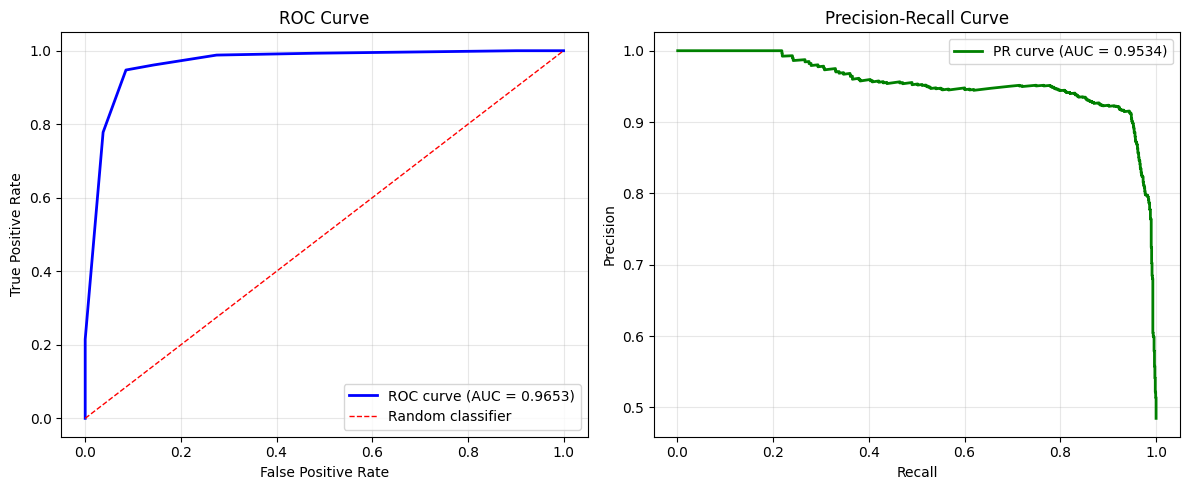

In [97]:
print("КРИВЫЕ КАЧЕСТВА:")
print("-" * 30)

# Вычисление AUC-ROC
fpr, tpr, auc_roc = calculate_auc_roc(y_test.values, y_proba)

# Вычисление AUC-PR
precision_curve, recall_curve, auc_pr = calculate_auc_pr(y_test.values, y_proba)

print(f"AUC-ROC: {auc_roc:.4f}")
print(f"AUC-PR: {auc_pr:.4f}")
print()

# Построение графиков
plt.figure(figsize=(12, 5))

# ROC-кривая
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, "b-", linewidth=2, label=f"ROC curve (AUC = {auc_roc:.4f})")
plt.plot([0, 1], [0, 1], "r--", linewidth=1, label="Random classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True, alpha=0.3)

# PR-кривая
plt.subplot(1, 2, 2)
plt.plot(recall_curve, precision_curve, "g-", linewidth=2, label=f"PR curve (AUC = {auc_pr:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Выводы

In [98]:
print("6. ВЫВОДЫ")
print("=" * 50)

# Accuracy = (TP + TN) / (TP + TN + FP + FN)
# Precision = TP / (TP + FP) — точность положительных прогнозов
# Recall = TP / (TP + FN) — полнота обнаружения положительных

print("\nОСНОВНЫЕ РЕЗУЛЬТАТЫ:")
print("-" * 30)
print(f"• Точность модели: {accuracy:.4f}")
print(f"• Precision: {precision:.4f}")
print(f"• Recall: {recall:.4f}")
print(f"• AUC-ROC: {auc_roc:.4f}")
print(f"• AUC-PR: {auc_pr:.4f}")

print("\nХАРАКТЕРИСТИКИ МОДЕЛИ:")
print("-" * 30)
print(f"• Количество признаков: {len(selected_features)}")
print(f"• Максимальная глубина дерева: {tree.max_depth}")
print(f"• Минимальное количество samples для разделения: {tree.min_samples_split}")
print(f"• Размер тестовой выборки: {len(X_test)} примеров")

print("\nРАСПРЕДЕЛЕНИЕ КЛАССОВ В ТЕСТОВОЙ ВЫБОРКЕ:")
print("-" * 30)
test_class_dist = Counter(y_test)
for cls, count in test_class_dist.items():
    percentage = count / len(y_test) * 100
    label = "poisonous" if cls == 1 else "edible"
    print(f"• {label}: {count} примеров ({percentage:.1f}%)")

6. ВЫВОДЫ

ОСНОВНЫЕ РЕЗУЛЬТАТЫ:
------------------------------
• Точность модели: 0.9307
• Precision: 0.9127
• Recall: 0.9475
• AUC-ROC: 0.9653
• AUC-PR: 0.9534

ХАРАКТЕРИСТИКИ МОДЕЛИ:
------------------------------
• Количество признаков: 4
• Максимальная глубина дерева: 5
• Минимальное количество samples для разделения: 10
• Размер тестовой выборки: 2437 примеров

РАСПРЕДЕЛЕНИЕ КЛАССОВ В ТЕСТОВОЙ ВЫБОРКЕ:
------------------------------
• edible: 1256 примеров (51.5%)
• poisonous: 1181 примеров (48.5%)
